In [ ]:
from pymongo import MongoClient
import itertools
import networkx as nx
import matplotlib.pyplot as plt

# connect
client = MongoClient("mongodb://localhost:27017/")
db = client["castle"]
col = db["images"]

# query (e.g., day1)
cursor = col.find({"day": 1})

# build graph
G = nx.Graph()

for doc in cursor:
    people = set(doc.get("people_present", []))
    people.add(doc["person"])  # include camera wearer
    for a, b in itertools.combinations(people, 2):
        if G.has_edge(a, b):
            G[a][b]['weight'] += 1
        else:
            G.add_edge(a, b, weight=1)

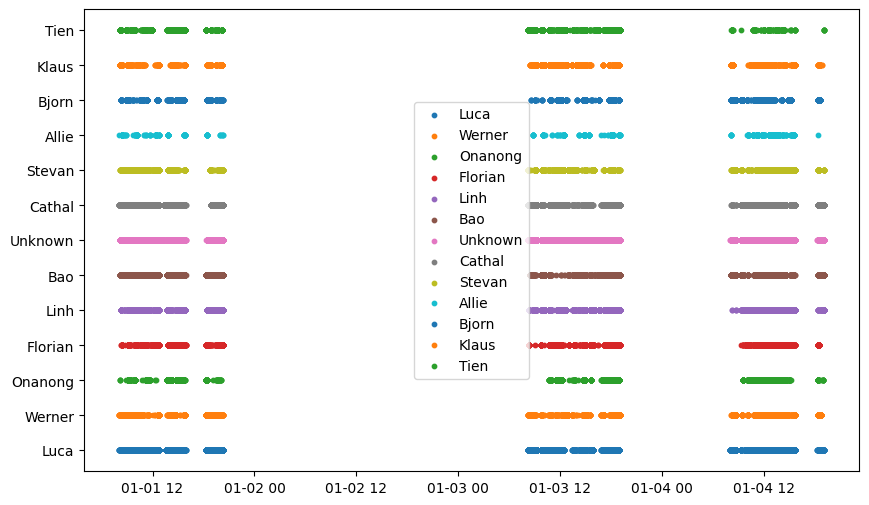

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# get one person’s frames
cam_id = "Allie"
cursor = col.find({"person": cam_id})

rows = []
for doc in cursor:
    ts = pd.to_datetime(doc["local_time"])
    for p in doc.get("people_present", []):
        rows.append({"time": ts.timestamp(), "local_time": ts, "other": p})

df = pd.DataFrame(rows)

# plot: scatter timeline
plt.figure(figsize=(10,6))
for i, person in enumerate(df["other"].unique()):
    subset = df[df["other"] == person]
    plt.scatter(subset["local_time"], [i]*len(subset), label=person, s=10)

plt.yticks(range(len(df["other"].unique())), df["other"].unique())
plt.legend()
plt.show()

<Figure size 1200x800 with 0 Axes>

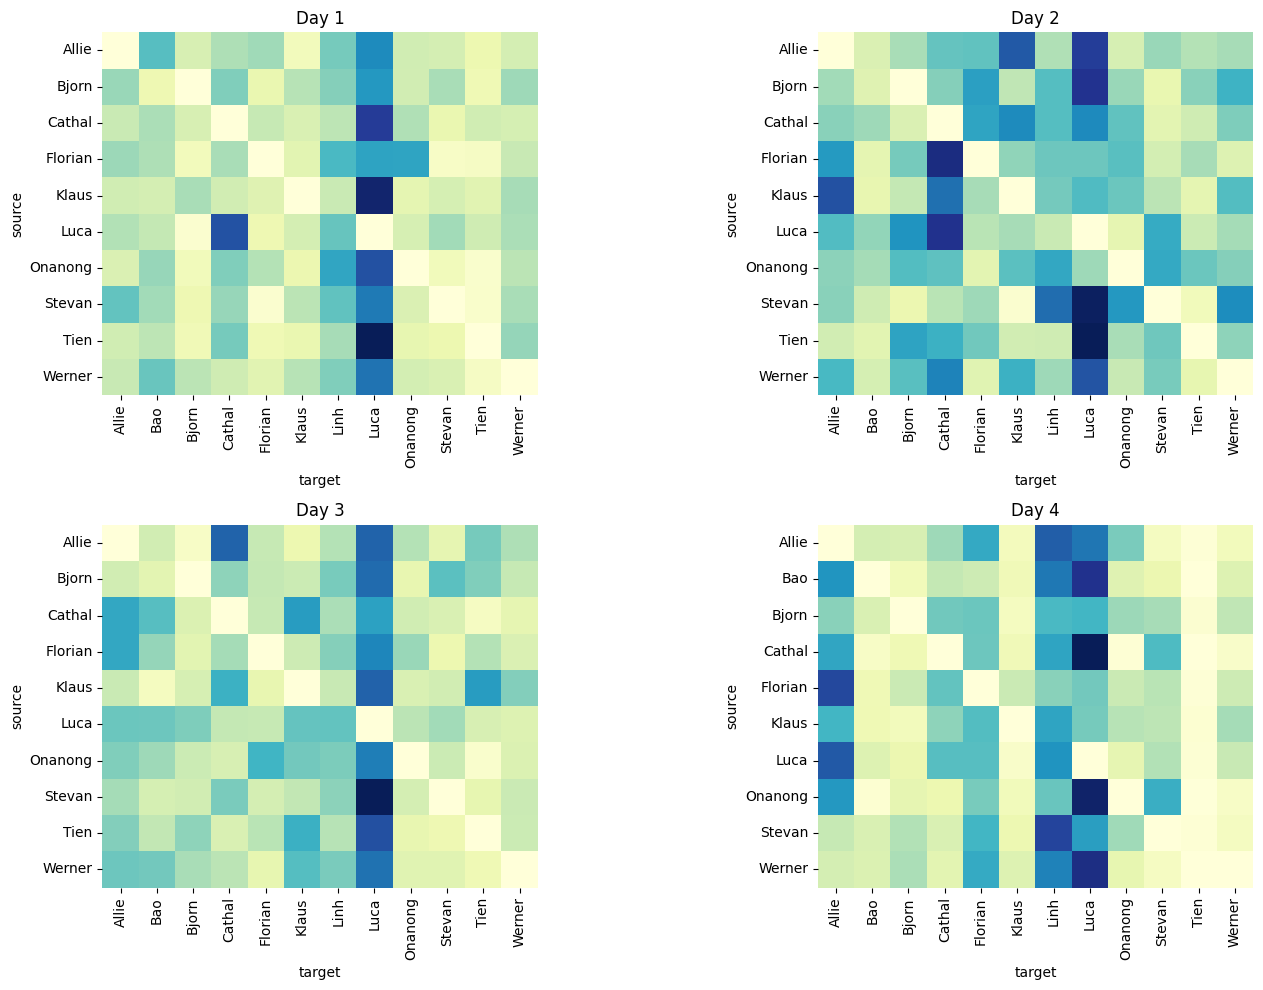

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_day_data(day: int):
    cursor = col.find({"day": day})
    rows = []
    for doc in cursor:
        wearer = doc.get("person", "")
        for other in doc.get("people_present", []):
            if other == "Unknown":
                continue  # skip Unknown
            if other != wearer:  # avoid self-loops
                rows.append((wearer, other))

    pairs = pd.DataFrame(rows, columns=["source","target"])
    counts = pairs.value_counts().reset_index(name="count")

    # Pivot to adjacency matrix (directed)
    source_people = counts["source"].unique()
    source_people.sort()
    target_people = counts["target"].unique()
    target_people.sort()
   
    matrix = counts.pivot(index="source", columns="target", values="count") \
                .reindex(index=source_people, columns=target_people).fillna(0)

    # normalise rows to sum to 1
    matrix = matrix.div(matrix.sum(axis=1), axis=0).fillna(0)

    return matrix


plt.figure(figsize=(12, 8))
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for day, ax in zip([1, 2, 3, 4], axes.flatten()):
    matrix = get_day_data(day)
    try:
        sns.heatmap(matrix, cmap="YlGnBu", ax=ax, square=True, cbar=False)
        ax.set_title(f"Day {day}")
    except Exception as e:
        print(f"Error processing day {day}: {e}")

plt.tight_layout()
plt.show()

/tmp/ipykernel_2137186/1121451239.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hour = ts.floor("H")  # round to the hour
/tmp/ipykernel_2137186/1121451239.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hour = ts.floor("H")  # round to the hour
/tmp/ipykernel_2137186/1121451239.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hour = ts.floor("H")  # round to the hour
/tmp/ipykernel_2137186/1121451239.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hour = ts.floor("H")  # round to the hour


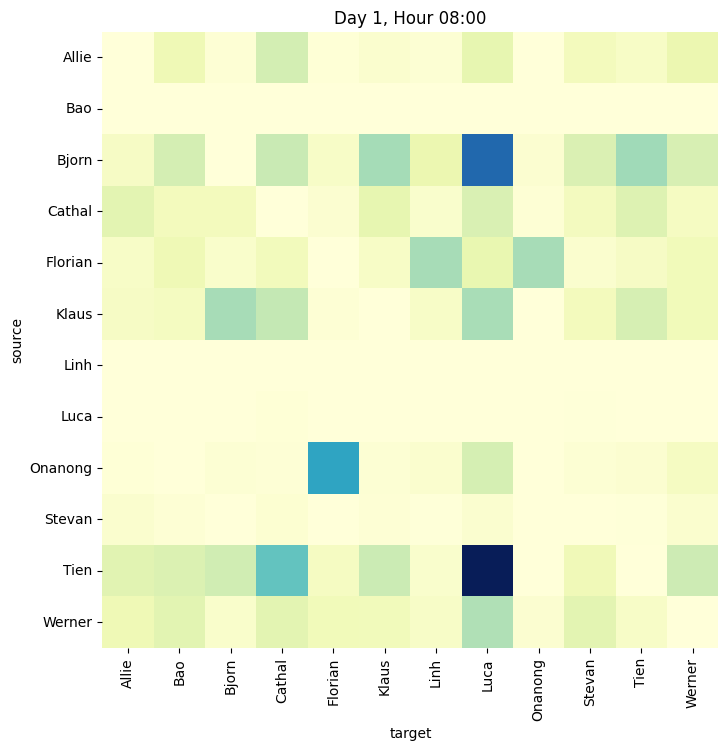

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def get_hourly_data(day: int):
    cursor = col.find({"day": day})
    rows = []
    for doc in cursor:
        wearer = doc.get("person", "")
        ts = pd.to_datetime(doc.get("local_time"))
        hour = ts.floor("H")  # round to the hour
        for other in doc.get("people_present", []):
            if other == "Unknown":
                continue  # skip Unknown
            if other != wearer:  # avoid self-loops
                rows.append((day, hour, wearer, other))

    df = pd.DataFrame(rows, columns=["day", "hour", "source", "target"])
    grouped = df.groupby(["day", "hour", "source", "target"]).size().reset_index(name="count")
    return grouped

# collect all days
all_data = pd.concat([get_hourly_data(d) for d in [1,2,3,4]])

# unique (day, hour) bins
time_bins = all_data[["day","hour"]].drop_duplicates().sort_values(["day","hour"]).values

fig, ax = plt.subplots(figsize=(10,8))

def update(frame):
    ax.clear()
    day, hour = time_bins[frame]
    sub = all_data[(all_data["day"]==day) & (all_data["hour"]==hour)]

    if sub.empty:
        ax.set_title(f"Day {day}, Hour {hour.strftime('%H:%M')} (no data)")
        return

    # pivot into adjacency matrix
    people = sorted(set(sub["source"]) | set(sub["target"]))
    matrix = sub.pivot(index="source", columns="target", values="count") \
                .reindex(index=people, columns=people).fillna(0)

    sns.heatmap(matrix, cmap="YlGnBu", square=True, cbar_kws={"shrink": 0.8}, ax=ax, cbar=False)
    ax.set_title(f"Day {day}, Hour {hour.strftime('%H:%M')}")

ani = animation.FuncAnimation(fig, update, frames=len(time_bins), interval=1500, repeat=False)

In [49]:
# In Jupyter, preview as HTML:
from IPython.display import HTML
HTML(ani.to_jshtml())

# Or save to mp3:
ani.save("heatmap_animation.mp4", writer="ffmpeg", fps=1)
